# Infra

In [3]:
from estimators.ccb import pdis_cressieread
import numpy as np
import pandas as pd
import random
import datetime

import matplotlib.pyplot as plt


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def explore(self, n):
        return self.epsilon / n

    def exploit(self, n):
        return self.epsilon / n + 1 - self.epsilon


class CcbSimulation(pd.DataFrame):
    def __init__(self, traffic: list, n_policies, reward_scale):
        slots = []
        traffic_pmf = [t[0] for t in traffic]
        t = datetime.datetime(2022,1,1,0,0,0)
        session=0
        for n, policy in n_policies:
            for _ in range(n):
                t += datetime.timedelta(minutes=1)
                traffic_idx = np.random.choice(range(len(traffic_pmf)), p=traffic_pmf)
                rewards = traffic[traffic_idx][1]
                nslots = len(rewards)
                state = policy
                session += 1
                for j in range(nslots):
                    id_pmf = [(k, v[0]) for k, v in state.items()]
                    pmf = [v for _, v in id_pmf]
                    chosen_idx = np.random.choice(range(len(pmf)), p=pmf)
                    chosen = id_pmf[chosen_idx][0]
                    state = state[chosen][1]
                    r = int(random.random() < rewards[j][chosen]) * reward_scale
                    slots.append({'t': t, 'session': session, 'slot': j, 'p_log': pmf[chosen_idx], 'r': r, 'chosen': chosen, 'chosen_idx': chosen_idx})
        super().__init__(slots)

    def predict(self, policy):
        p_pred = []
        for _, e in self.sessions.iterrows():
            state = policy
            for i in range(len(e['p_log'])):
                id_pmf = {k: v[0] for k, v in state.items()}
                chosen = e['chosen'][i]
                p_pred.append(id_pmf[chosen])
                state = state[chosen][1]
        self['p_pred'] = p_pred

    def cfe(self, window):
        def init_estimator(**kwargs):
            result = pdis_cressieread.Estimator()
            result.add_example(**kwargs)
            return result
        result = pd.DataFrame()
        result['estimator'] = self.sessions.set_index('t').apply(lambda row: init_estimator(p_logs=row['p_log'], rs=row['r'], p_preds=row['p_pred']), axis=1)
        result = result.resample(window).sum()
        r = result.apply(lambda row: row['estimator'].get(), axis=1)
        nslots = self['slot'].max() + 1
        for i in range(nslots):
            result[f'r[{i}]'] = r.str[i]
        return result
    
    @property
    def sessions(self):
        agg = {'t': 'first', 'p_log': list, 'r': list, 'chosen': list, 'chosen_idx': list}
        if 'p_pred' in self.columns:
            agg['p_pred'] = list
        return self.groupby('session').agg(agg)


# Simulation

In [4]:
epsilon = 0.05

# sclalar for all reward values
reward_scale = 0.01

rewards = np.array([
    [0.6, 0.8, 0],
    [0.8, 0.6, 0]])

traffic = [(1, rewards)] # 100% percent of traffic is based on rewards matrix (#actions x #slots matrix of bernoullly parameters)

eg = EpsilonGreedy(epsilon)

# policy 01, preferring to play action 0 on first slot and action 1 on second slot
epsilon_greedy_01 = {
    0: (eg.exploit(3), {               
        1: (eg.exploit(2), {}),        
        2: (eg.explore(2), {}),        
    }),
    1: (eg.explore(3), {               
        0: (0.5, {}),        
        2: (0.5, {}),        
    }),
    2: (eg.explore(3), {               
        0: (0.5, {}),        
        1: (0.5, {}),        
    })
}

# policy 10, preferring to play action 1 on first slot, and action 0 on second slot
epsilon_greedy_10 = {
    0: (eg.explore(3), {               
        1: (0.5, {}),        
        2: (0.5, {}),        
    }),
    1: (eg.exploit(3), {               
        0: (eg.exploit(2), {}),        
        2: (eg.explore(2), {}),        
    }),
    2: (eg.explore(3), {               
        0: (0.5, {}),        
        1: (0.5, {}),        
    })
}

n = 100000

# simulate us making first n decisions using policy 01 and then n decisions using policy 10
logs_cfe = CcbSimulation(traffic, [(n, epsilon_greedy_01), (n, epsilon_greedy_10)], reward_scale=reward_scale)
# generate p_preds for 01 policy
logs_cfe.predict(epsilon_greedy_01)
# do cfe
cfe = logs_cfe.cfe(window='12h')

# simulate us making all decisions using policy 01
logs_sim = CcbSimulation(traffic, [(2 * n, epsilon_greedy_01)], reward_scale=reward_scale)

# Visualize

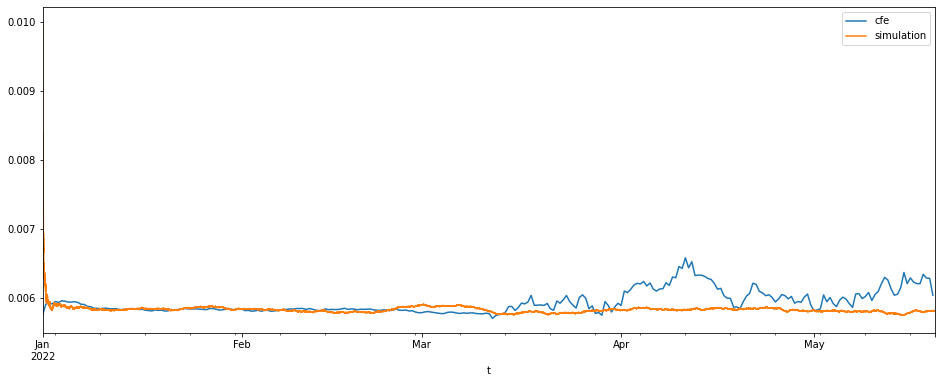

In [5]:
window='14d'

cfe['r[1]'].rolling(window=window).mean().plot(label='cfe', figsize=[16,6])
sim = logs_sim.set_index('t')
sim[sim.slot==1]['r'].rolling(window=window).mean().plot(label='simulation', figsize=[16,6])
plt.legend()